<a href="https://colab.research.google.com/github/ribesstefano/chalmers_dat340_applied_machine_learning/blob/main/assignment_2/DAT340_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Group PA 47 - Author: Stefano Ribes, ribes@chalmers.se

This Notebook can be viewed online at this link: https://colab.research.google.com/drive/1sMNNrs7crcaSTpWAKSQG6BNoK8-KPbMg?usp=sharing

# Programming Assignment 2: Random Forests

## Task 0: Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

ASSIGNMENT_ID = 'assignment_2'

data_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
data_dir = os.path.join(data_dir, 'Colab Notebooks', 'dat340', ASSIGNMENT_ID)
data_dir = os.path.join(data_dir, 'data')
data_dir

'/content/drive/MyDrive/Colab Notebooks/dat340/assignment_2/data'

In [ ]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

## Task 1: Working with a dataset with categorical features

### Step 1. Reading the data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def get_dataset(filename):
    # Read the CSV file of data.
    data = pd.read_csv(filename).dropna()
    # Shuffle the dataset.
    data_shuffled = data.sample(frac=1.0, random_state=0)
    # Split into input part X and output part Y.
    X = data_shuffled.drop('target', axis=1)
    Y = data_shuffled['target'].to_frame()
    return X, Y

filename = os.path.join(data_dir, 'adult_train.csv')
Xtrain, Ytrain = get_dataset(filename)

filename = os.path.join(data_dir, 'adult_test.csv')
Xtest, Ytest = get_dataset(filename)

Xtest

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
15729,44,Private,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,48,United-States
7077,37,Private,HS-grad,9,Divorced,Exec-managerial,Unmarried,White,Female,0,0,50,United-States
14946,35,Private,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,45,United-States
9416,38,State-gov,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States
5739,41,Private,HS-grad,9,Married-civ-spouse,Adm-clerical,Wife,White,Female,5013,0,30,United-States


### Step 2. Encoding the features as numbers.

The `to_dict()` method of a pandas data frame allows to generate a list of dictionaries, _i.e._ one dictionary per table entry.

In [ ]:
from sklearn.feature_extraction import DictVectorizer

Xtrain.to_dict('records')[:2]

[{'age': 49,
  'capital-gain': 0,
  'capital-loss': 0,
  'education': 'HS-grad',
  'education-num': 9,
  'hours-per-week': 40,
  'marital-status': 'Married-civ-spouse',
  'native-country': 'United-States',
  'occupation': 'Transport-moving',
  'race': 'White',
  'relationship': 'Husband',
  'sex': 'Male',
  'workclass': 'Local-gov'},
 {'age': 49,
  'capital-gain': 0,
  'capital-loss': 0,
  'education': 'HS-grad',
  'education-num': 9,
  'hours-per-week': 40,
  'marital-status': 'Divorced',
  'native-country': 'United-States',
  'occupation': 'Other-service',
  'race': 'Black',
  'relationship': 'Not-in-family',
  'sex': 'Female',
  'workclass': 'Private'}]

The `DictVectorizer` transforms the list of dictionaries into a "learned" matrix of features.

In [ ]:
dv = DictVectorizer(sparse=False)
# Input training data
Xtrain_encoded = dv.fit_transform(Xtrain.to_dict('records'))
# Input test data
Xtest_encoded = dv.transform(Xtest.to_dict('records'))
Xtrain_encoded.shape

(32561, 107)

Note that before the vetorization the dataset had 13 columns, _i.e._ each entry had 13 fields. After fitting the dataset via `DictVectorizer` instead, the resulting vectorized dataset now has 107 "columns" (_i.e._ features).

On the other hand, the output data are transformed into one-hot encoding data: since there are only two classes, the output shape is equal to `(N, 2)`.

In [ ]:
dv = DictVectorizer(sparse=False, separator='')
# Output training data
Ytrain_encoded = dv.fit_transform(Ytrain.to_dict('records'))
# Output testing data
Ytest_encoded = dv.transform(Ytest.to_dict('records'))
print(dv.get_feature_names_out(['target']))
print(type(Ytrain_encoded))
print(Ytrain_encoded.shape)
print(Ytrain_encoded)

['target<=50K' 'target>50K']
<class 'numpy.ndarray'>
(32561, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


Now that the datasets are cleaned, we can try some classifiers on it, _i.e._ apply cross-validation.

In [ ]:
# Baseline: Dummy Classifier
from sklearn.dummy import DummyClassifier
# Tree-based classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Linear classifiers
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
# Neural network classifier (will take longer time to train)
from sklearn.neural_network import MLPClassifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

def aggregate_scores(scores):
    return scores.mean()

models = {
    'Baseline' : DummyClassifier(strategy='most_frequent'),
    'DecisionTreeClassifier' : DecisionTreeClassifier(max_depth=None), # None: till necessary
    'RandomForestClassifier' : RandomForestClassifier(n_estimators=80), # 100
    # 'GradientBoostingClassifier' : GradientBoostingClassifier(n_estimators=100),
    # 'LogisticRegression' : LogisticRegression(solver='saga', max_iter=2000, tol=0.1, C=5.5),
    # 'Perceptron' : Perceptron(early_stopping=True, tol=0.01),
    # 'LinearSVC' : LinearSVC(dual=False, max_iter=2000, tol=0.0001, C=2.),
    'MLPClassifier' : MLPClassifier(hidden_layer_sizes=(32, 32, 32,), learning_rate_init=0.01, batch_size=128, max_iter=100),
}

scores = {}

for model_type in models.keys():
    model = models[model_type]
    score = aggregate_scores(cross_val_score(model, Xtrain_encoded, Ytrain_encoded))
    scores[model_type] = score
    print(f'INFO. Model {model_type} aggregated score: {score:.4f}')

best_model_type = max(scores, key=scores.get)
print('=' * 80)
print(f'INFO. Best Model is {best_model_type} with score: {scores[best_model_type]:.4f}')

INFO. Model Baseline aggregated score: 0.7592
INFO. Model DecisionTreeClassifier aggregated score: 0.8069
INFO. Model RandomForestClassifier aggregated score: 0.8439


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


INFO. Model MLPClassifier aggregated score: 0.8238
INFO. Best Model is RandomForestClassifier with score: 0.8439


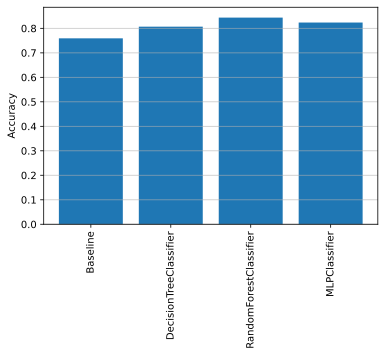

In [ ]:
import matplotlib.pyplot as plt

linspace = [x for x in range(len(models.keys()))]
plt.bar(linspace, scores.values())
plt.xticks(linspace, [f'{m}' for m in models.keys()], rotation=90)
plt.grid(which='both', axis='y', alpha=0.7, zorder=1)
plt.ylabel('Accuracy')
plt.title('Accuracy score of different classifiers')
plt.show()

In [ ]:
models[best_model_type].fit(Xtrain_encoded, Ytrain_encoded)
acc_orig = accuracy_score(Ytest_encoded, models[best_model_type].predict(Xtest_encoded))
print(f'INFO. Original accuracy: {acc_orig:.4f}')

INFO. Original accuracy: 0.8418


### Step 3. Combining the steps.

We can combine the vectorization and the model into a single pipeline object as follows:

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
  
pipeline = make_pipeline(
  DictVectorizer(sparse=False),
  clone(models[best_model_type]) # Cloning effectively resets training
)
pipeline

Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=80))])

We can then call `fit()` on the pipeline object and perform bothe cleaning and model training in one function call.

In [ ]:
pipeline.fit(Xtrain.to_dict('records'), Ytrain_encoded)

Pipeline(steps=[('dictvectorizer', DictVectorizer(sparse=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=80))])

Once trained, the model should perform similarly to the model trained _without_ being in a pipeline.

In [ ]:
Ypred = pipeline.predict(Xtest.to_dict('records'))
pipeline_acc = accuracy_score(Ytest_encoded, Ypred)
print(f'INFO. Pipeline accuracy: {pipeline_acc:.4f}')
print(f'INFO. Original vs. Pipeline accuracy difference: {acc_orig - pipeline_acc:.4f}')

INFO. Pipeline accuracy: 0.8436
INFO. Original vs. Pipeline accuracy difference: -0.0018


Note that the transformation is not applied to the output datasets, _i.e._ `Ytrain` and `Ytest`. (TODO: is there a way to do that through the Pipeline?).

## Task 2: Decision trees and random forests

### Underfitting and overfitting in decision tree classifiers.

In [ ]:
eval_scores_train = {}
eval_scores_test = {}
table_data = []

for depth in range(1, 13):
    model_id = f'd={depth}'
    model = DecisionTreeClassifier(max_depth=depth)
    # Training
    model.fit(Xtrain_encoded, Ytrain_encoded)
    # Evaluation
    train_acc = accuracy_score(Ytrain_encoded, model.predict(Xtrain_encoded))
    test_acc = accuracy_score(Ytest_encoded, model.predict(Xtest_encoded))
    # Logging
    eval_scores_train[model_id] = train_acc
    eval_scores_test[model_id] = test_acc
    table_data.append([depth, train_acc, test_acc])
    # print(f'INFO. Model with depth={depth} achieved test accuracy of: {test_acc:.4f}')
table_columns = ['Max Depth', 'Train Accuracy', 'Test Accuracy']
decision_tree_df = pd.DataFrame(table_data, columns=table_columns)
decision_tree_df

,Max Depth,Train Accuracy,Test Accuracy
0,1,0.759190,0.763774
1,2,0.828230,0.830662
2,3,0.843893,0.844788
3,4,0.843893,0.844788
4,5,0.851970,0.852220
5,6,0.857068,0.857380
6,7,0.858205,0.856458
7,8,0.860569,0.856888
8,9,0.835355,0.830170
9,10,0.867633,0.858977


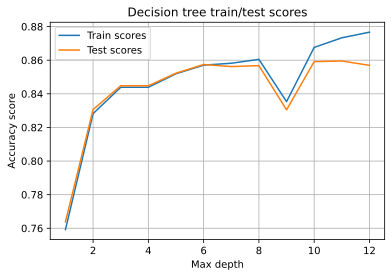

In [ ]:
x = range(1, 13)
plt.plot(x, list(eval_scores_train.values()), label='Train scores')
plt.plot(x, list(eval_scores_test.values()), label='Test scores')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
# plt.ylim([0, 1])
plt.title('Decision tree train/test scores')
plt.grid()
plt.show()

As the maximum depth increases, we see an improvement on the model performance. Moreover, we do not observe a significant difference in the train/test score curves, meaning that the model is not overfitted.

### Underfitting and overfitting in random forest classifiers.

In [ ]:
import time

eval_scores_train = {}
eval_scores_test = {}
table_data = []

for estimators in [1] + list(range(0, 300, 50))[1:]:
    model_id = f'{estimators}'
    eval_scores_train[model_id] = []
    eval_scores_test[model_id] = []
    # print('=' * 80)
    # print(f'N. Estimators: ')
    # print('=' * 80)
    for depth in range(1, 13):
        model = RandomForestClassifier(max_depth=depth, n_estimators=estimators,
                                       n_jobs=8)
        # Training
        start_time = time.time()
        model.fit(Xtrain_encoded, Ytrain_encoded)
        stop_time = time.time()
        train_time = stop_time - start_time
        # Evaluation
        train_acc = accuracy_score(Ytrain_encoded, model.predict(Xtrain_encoded))
        test_acc = accuracy_score(Ytest_encoded, model.predict(Xtest_encoded))
        # Logging
        eval_scores_train[model_id].append(train_acc)
        eval_scores_test[model_id].append(test_acc)
        table_data.append([estimators, depth, train_acc, test_acc, train_time])
        # print(f'INFO. Model with depth={depth} and estimators={estimators}, achieved test accuracy of: {test_acc:.4f}')
table_columns = [
                 'N. Estimators', 'Max Depth', 'Train Accuracy',
                 'Test Accuracy', 'Training Time [s]'
                ]
random_forest_df = pd.DataFrame(table_data, columns=table_columns)
random_forest_df

,N. Estimators,Max Depth,Train Accuracy,Test Accuracy,Training Time [s]
0,1,1,0.759190,0.763774,0.120895
1,1,2,0.771966,0.774522,0.120489
2,1,3,0.817850,0.819176,0.120203
3,1,4,0.799699,0.802039,0.120718
4,1,5,0.763122,0.767705,0.120125
...,...,...,...,...,...
67,250,8,0.856700,0.853203,5.386783
68,250,9,0.859003,0.855291,5.681913
69,250,10,0.864593,0.859652,6.011736
70,250,11,0.867387,0.859775,6.374560


Let us now plot the training and testing score curves for difference ensemble sizes and increasing the maximum depth of the estimators.

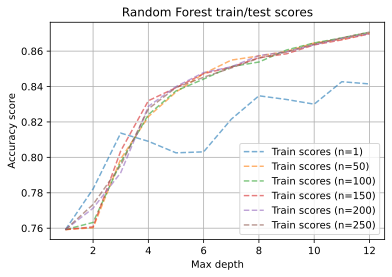

In [ ]:
for n in eval_scores_train.keys():
    plt.plot(range(1, 13), eval_scores_train[n], '--', label=f'Train scores (n={n})', alpha=0.6)

# for n in eval_scores_test.keys():
#     plt.plot(range(1, 13), eval_scores_test[n], label=f'Test scores (n={n})', alpha=0.6)

plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
plt.title('Random Forest train/test scores')
# plt.xlim([0, 1])
plt.grid()
plt.show()

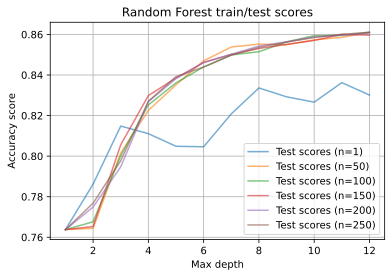

In [ ]:
for n in eval_scores_test.keys():
    plt.plot(range(1, 13), eval_scores_test[n], label=f'Test scores (n={n})', alpha=0.6)

plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
plt.title('Random Forest train/test scores')
# plt.xlim([0, 1])
plt.grid()
plt.show()

<!-- > Some things that you might want to discuss in your report:
> * What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?
> * What happens with the curve for random forests as the ensemble size grows?
> * What happens with the best observed test set accuracy as the ensemble size grows?
> * What happens with the training time as the ensemble size grows? -->
Some conclusions regarding the comparison between DTC and RFC:

* As for DTC, the RFC train/test curves suggest that the tested models are not overfitting.
* For ensemble size of 1, the Random Forest Classifier (RFC) and the Decision Tree Classifier (DTC) behave similarly, _i.e._ as the maximum depth increases so does the accuracy. In general, increasing the depth of the trees reduces the bias of the model, _i.e._ it helps with regularization. However, the RFC curve appear to be more "oscillating", not really monotonically increasing. This difference in the curves lies in the fact that each tree in the RFC is built _incorporating randomness_, whereas a DTC is not. Hence the single tree in a RFC with `n_estimators=1` won't be equal to the tree of a DTC.

* As the number of ensembles increases, the curve seems to become "smoother", converging to a monotonically increasing function. In practice it seems that increasing the number of estimators makes the RFC converge to a certain accuracy score.
<!-- > * What happens with the best observed test set accuracy as the ensemble size grows? -->
* According to the graph show below, the training time both depends on max depth and the ensemble size. If we consider the max depth fixed, however, we can see that the training time is linearly increasing as the number of ensembles grows.


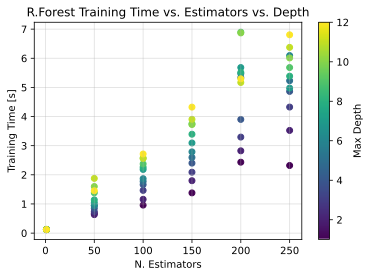

In [ ]:
plt.scatter(random_forest_df['N. Estimators'],
            random_forest_df['Training Time [s]'],
            c=random_forest_df['Max Depth'])
# plt.legend()
plt.xlabel('N. Estimators')
plt.ylabel('Training Time [s]')
plt.title('R.Forest Training Time vs. Estimators vs. Depth')
plt.colorbar(label='Max Depth')
# plt.xlim([0, 1])
plt.grid(alpha=0.4)
plt.show()

## Task 3: Feature importances in random forest classifiers

Let us extract the most important features from the RFC and the Vectorizer.

In [ ]:
vectorizer = pipeline.steps[0][1]
randforest = pipeline.steps[1][1]
# Get indeces of sorted importance values, then the sorted feature names
sorted_idx = (-randforest.feature_importances_).argsort()
features_names = vectorizer.get_feature_names_out()[sorted_idx]
features_vals = randforest.feature_importances_[sorted_idx]
# Logging
table_data = []
for elem in zip(features_names, features_vals):
    table_data.append(elem)
pd.DataFrame(table_data, columns=['Feature Name', 'Importance'])

,Feature Name,Importance
0,age,2.295775e-01
1,hours-per-week,1.146271e-01
2,capital-gain,1.040436e-01
3,education-num,7.263606e-02
4,marital-status=Married-civ-spouse,6.366235e-02
...,...,...
102,native-country=Outlying-US(Guam-USVI-etc),2.521825e-05
103,occupation=Armed-Forces,1.086699e-05
104,native-country=Honduras,4.569113e-06
105,workclass=Never-worked,2.252197e-06


It seems that the _age_ is the feature that best divides the data set.

Sklearn default way of computing the feature importance is to measure, at training time, how well each feature decreases the impurity of the split. The measurement is then averaged across the training steps and averaged again across the ensembles, such that a single importance score per feature is obtained [1].

Another possible method for estimating features importance is to utilize _permutations of features_ [2]: intuitively, given a fitted model with a known performance score, each feature, _i.e._ column, is randomly swapped and the score of the classifier is computed. The average drop in perfomance can then be used as a score for feature importance. In fact, the idea is that features with the highest performance drop will account the most and therefore have the highest importance score.

References:

* [1] Random Forest Feature Importance Computed in 3 Ways with Python, link: https://mljar.com/blog/feature-importance-in-random-forest/
* [2] Permutation feature importance, link: https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

## Converting Notebook to PDF

The following two cells can be ignored for grading, as they just convert this notebook into a PDF file.

In [ ]:
%%capture
!apt-get update
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic
!apt-get install -y inkscape
!add-apt-repository -y universe
!add-apt-repository -y ppa:inkscape.dev/stable
!apt-get update -y
!apt install -y inkscape

In [ ]:
%%capture
import re

ASSIGNMENT_NAME = 'DAT340 - Assignment ' + ASSIGNMENT_ID.split('_')[1]
pdf_dir = os.path.join(os.path.abspath(''), 'drive', 'MyDrive')
pdf_dir = os.path.join(pdf_dir, 'Colab Notebooks', 'dat340', ASSIGNMENT_ID)
pdf_filename = re.escape(os.path.join(pdf_dir, ASSIGNMENT_NAME)) + '.ipynb'

!jupyter nbconvert --to pdf --TemplateExporter.exclude_input=False $pdf_filename